# 1. Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2

# 2. Load Data

The data is manually gathered of my own face using python libraries open cv to capture images around 90 and then manually annotations on each image to generate labels in the format of .json

## 2.1 Creating Necessary Folders

In [2]:
import os

# Define the base path
base_path = "/content/drive/MyDrive/data"

# Define the required folders
folders = [
    "train/images", "train/labels",
    "test/images", "test/labels",
    "val/images", "val/labels",
    "data_augmentation/train/images", "data_augmentation/train/labels",
    "data_augmentation/test/images", "data_augmentation/test/labels",
    "data_augmentation/val/images", "data_augmentation/val/labels"
]

# Create the folders
for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

print("Folders created successfully!")


Folders created successfully!


```
data/
├── train/
│   ├── images/
│   ├── labels/
├── test/
│   ├── images/
│   ├── labels/
├── val/
│   ├── images/
│   ├── labels/
├── data_augmentation/
│   ├── train/
│   │   ├── images/
│   │   ├── labels/
│   ├── test/
│   │   ├── images/
│   │   ├── labels/
│   ├── val/
│   │   ├── images/
│   │   ├── labels/

```



# 3. Loading Images into Tensorflow Pipeline

In [3]:
images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/images/*.jpg')

In [4]:
img = images.as_numpy_iterator().next()

In [5]:
img

b'/content/drive/MyDrive/data/images/06456368-e0b1-11ef-9b65-38d57a32e57a.jpg'

In [ ]:
# tf.io.read_file(img)

In [6]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

array([[[209, 212, 201],
        [210, 213, 202],
        [210, 213, 202],
        ...,
        [173, 172, 170],
        [175, 173, 174],
        [175, 173, 174]],

       [[213, 216, 205],
        [213, 216, 205],
        [211, 214, 203],
        ...,
        [172, 171, 169],
        [170, 168, 169],
        [169, 167, 168]],

       [[211, 214, 203],
        [211, 214, 203],
        [209, 212, 201],
        ...,
        [174, 174, 172],
        [171, 171, 171],
        [169, 169, 169]],

       ...,

       [[167, 178, 174],
        [169, 180, 176],
        [168, 179, 175],
        ...,
        [ 43,  37,  21],
        [ 52,  46,  32],
        [ 53,  50,  33]],

       [[166, 178, 174],
        [169, 181, 177],
        [168, 180, 176],
        ...,
        [ 38,  41,  24],
        [ 47,  49,  35],
        [ 50,  53,  36]],

       [[165, 177, 173],
        [169, 181, 177],
        [169, 181, 177],
        ...,
        [ 36,  40,  25],
        [ 37,  44,  28],
        [ 40,  47,  31]]], dtype=uint8)
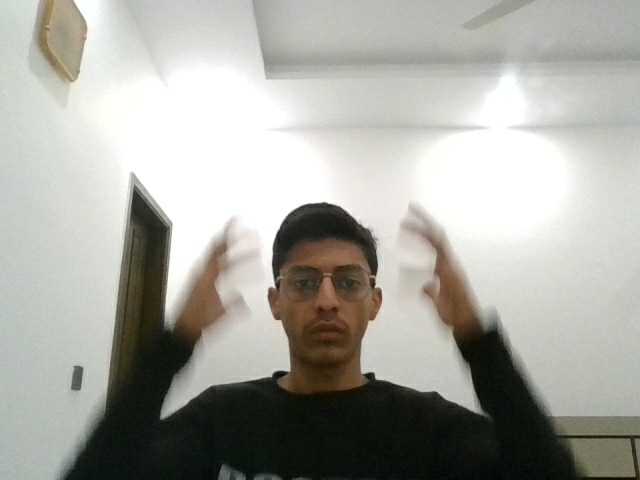

In [8]:
images.as_numpy_iterator().next() ## showing the image in an array

#

# 4. Visualize Using Matplotlib

4 images in a single batch

In [9]:
batch = images.batch(4).as_numpy_iterator().next()

In [10]:
 batch.shape

(4, 480, 640, 3)

4 batches, 480 and 640 size of image, 3 color channels RGB

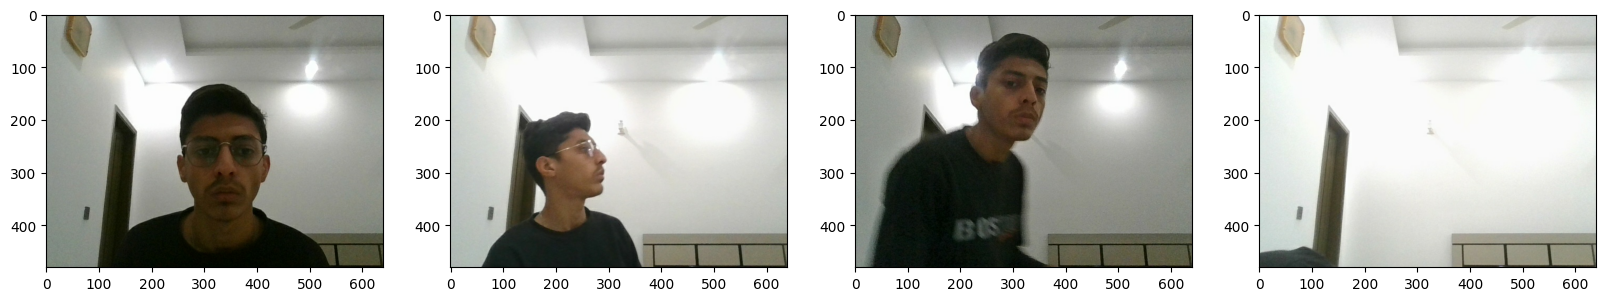

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(batch):
    ax[idx].imshow(image)
plt.show()

# 5. Partioning Data

In [12]:
train_dir = '/content/drive/MyDrive/data/train/images'
test_dir = '/content/drive/MyDrive/data/test/images'
val_dir = '/content/drive/MyDrive/data/val/images'

70% data -> training
15% data -> test
15% data -> val

In [13]:
image_list = list(images)

 Converting it into a list for more easy and efficient task

In [14]:
len(image_list)

91

## 5.1 Taking Size Of Train,Test,Val

In [15]:
train_size = int(len(image_list)*0.7)
test_size = int(len(image_list)*0.15)
val_size = int(len(image_list)*0.15)+2

In [16]:
print(f"train size:{train_size}\ntest size:{test_size}\nval size:{val_size}\nTotal Size:{train_size+test_size+val_size}")

train size:63
test size:13
val size:15
Total Size:91


## 5.2 Random Shuffle

In [17]:
import random

## 5.3 Splitting Data

In [18]:
img_dir = '/content/drive/MyDrive/data/images'

In [19]:
image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

In [21]:
train_images = image_files[:train_size]
test_images = image_files[train_size:train_size + test_size]
val_images = image_files[train_size + test_size:]

In [22]:
len(val_images)

15

In [23]:
import shutil

In [24]:
def move_images(image_list, target_dir):
    for img in image_list:
        src_path = os.path.join(img_dir, img)
        dest_path = os.path.join(target_dir, img)
        shutil.copy(src_path, dest_path)

In [25]:
move_images(train_images, train_dir)

In [26]:
move_images(test_images, test_dir)

In [27]:
move_images(val_images, val_dir)

## 5.4 Splitting Matching Labels

In [33]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/drive/MyDrive/data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/drive/MyDrive/data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('/content/drive/MyDrive/data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 6. Applying Data Augmentation

## 6.1 Testing On Single Picture

In [29]:
import albumentations as alb
import json

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [30]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [69]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/data','train', 'images','924bd839-e0b0-11ef-9d99-38d57a32e57a.jpg'))

In [70]:
with open(os.path.join('/content/drive/MyDrive/data', 'train', 'labels', '924bd839-e0b0-11ef-9d99-38d57a32e57a.json'), 'r') as f:
    label = json.load(f)

In [71]:
label

{'version': '5.6.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[178.6111111111111, 117.77777777777777],
    [421.9444444444444, 395.55555555555554]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\924bd839-e0b0-11ef-9d99-38d57a32e57a.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVY

In [66]:
len(label['shapes'])

0

In [47]:
label['shapes'][0]['points']

IndexError: list index out of range

In [36]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [37]:
coords = list(np.divide(coords, [640,480,640,480]))

In [38]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

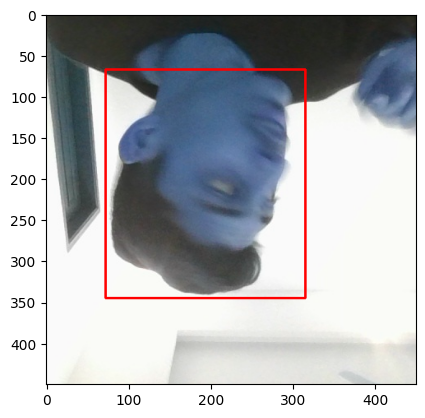

In [40]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [41]:
len(augmented['bboxes'])

1

## 6.2 Applying On All Images


In [81]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('/content/drive/MyDrive/data', partition, 'images')):
        img = cv2.imread(os.path.join('/content/drive/MyDrive/data', partition, 'images', image))
        # print(img)
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('/content/drive/MyDrive/data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            if len(label['shapes']) > 0:
              coords[0] = label['shapes'][0]['points'][0][0]
              coords[1] = label['shapes'][0]['points'][0][1]
              coords[2] = label['shapes'][0]['points'][1][0]
              coords[3] = label['shapes'][0]['points'][1][1]
              coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/drive/MyDrive/data/data_augmentation', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('/content/drive/MyDrive/data/data_augmentation', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

/usr/local/lib/python3.11/dist-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


In [ ]:
# import os
# import cv2
# import json
# import numpy as np

# # Loop through partitions (train, test, val)
# for partition in ['train', 'test', 'val']:

#     # Loop through each image in the images folder
#     for image in os.listdir(os.path.join('/content/drive/MyDrive/data', partition, 'images')):
#         img_path = os.path.join('/content/drive/MyDrive/data', partition, 'images', image)
#         img = cv2.imread(img_path)

#         coords = [0, 0, 0.00001, 0.00001]
#         label_path = os.path.join('/content/drive/MyDrive/data', partition, 'labels', f'{image.split(".")[0]}.json')

#         # Check if the label file exists
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             # Check if the 'shapes' list is not empty
#             if len(label['shapes']) > 0:
#                 coords[0] = label['shapes'][0]['points'][0][0]
#                 coords[1] = label['shapes'][0]['points'][0][1]
#                 coords[2] = label['shapes'][0]['points'][1][0]
#                 coords[3] = label['shapes'][0]['points'][1][1]
#                 coords = list(np.divide(coords, [640, 480, 640, 480]))
#             else:
#                 print(f"Warning: No shapes data in label for image {image}")
#                 # Handle case where there are no shapes, e.g., set default coordinates or skip
#                 coords = [0, 0, 0, 0]
#         else:
#             print(f"Warning: Label file does not exist for image {image}")
#             # Handle case where label file is missing, e.g., set default coordinates or skip
#             coords = [0, 0, 0, 0]
#         try:
#             # Ensure the augmented directories exist
#             os.makedirs(os.path.join('/content/drive/MyDrive/data/augmented_data', partition, 'images'), exist_ok=True)
#             os.makedirs(os.path.join('/content/drive/MyDrive/data/augmented_data', partition, 'labels'), exist_ok=True)

#             # Augment the images
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
#                 augmented_image_path = os.path.join('/content/drive/MyDrive/data/augmented_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg')
#                 cv2.imwrite(augmented_image_path, augmented['image'])

#                 # Create the annotation dictionary
#                 annotation = {}
#                 annotation['image'] = image

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0, 0, 0, 0]
#                         annotation['class'] = 0
#                     else:
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
#                 else:
#                     annotation['bbox'] = [0, 0, 0, 0]
#                     annotation['class'] = 0

#                 # Save the annotation to the labels folder
#                 annotation_path = os.path.join('/content/drive/MyDrive/data/augmented_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json')
#                 with open(annotation_path, 'w') as f:
#                     json.dump(annotation, f)

#         except Exception as e:
#             print(e)


x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].


/usr/local/lib/python3.11/dist-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].
x_max is less than or equal to x_min for bbox [0. 0. 0. 0. 0.].


# 6.3 Loading Augmented Images to Tf


In [83]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [84]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [85]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [91]:
batch = val_images.batch(4).as_numpy_iterator().next()

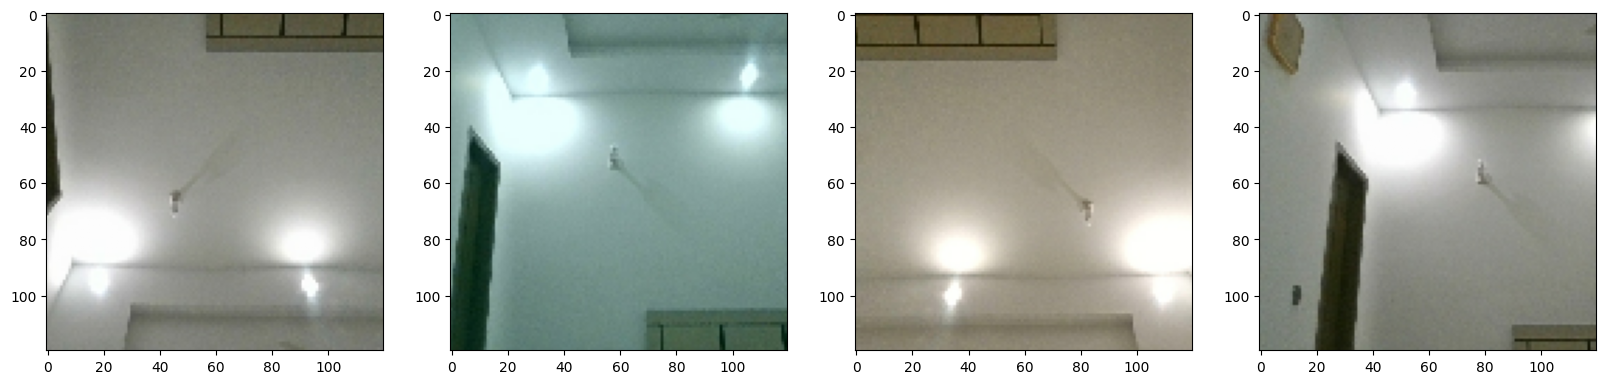

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(batch):
    ax[idx].imshow(image)
plt.show()

## 6.4 Setting Up Labels For Each Folder

In [108]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [109]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [111]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3748, 0.2217, 0.9155, 0.839 ], dtype=float16))

In [112]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [113]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/data_augmentation/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Merging Both Input And Label

In [114]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 900, 900)

In [115]:
len(train_labels)

3780

## 7.1 Splitting Into DataSets

In [116]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [117]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [118]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [120]:
test.as_numpy_iterator().next()[1][0][0]

array([0], dtype=uint8)

## 7.2 Visualizing Image With Borders


In [121]:
data_samples = train.as_numpy_iterator()

In [122]:
res = data_samples.next()

In [123]:
type(res)

tuple

In [126]:
res[1]

(array([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2095 , 0.261  , 0.6045 , 0.7017 ],
        [0.3801 , 0.305  , 0.77   , 0.8125 ],
        [0.1584 , 0.253  , 0.598  , 0.912  ],
        [0.4592 , 0.2556 , 0.7837 , 0.6543 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.677  , 0.05554, 1.     , 0.758  ],
        [0.331  , 0.3162 , 0.6616 , 0.7236 ],
        [0.2169 , 0.1963 , 0.4922 , 0.58   ]], dtype=float16))

In [127]:
res[1][1][1]

array([0.3801, 0.305 , 0.77  , 0.8125], dtype=float16)

In [130]:
type(res[0][0])

numpy.ndarray

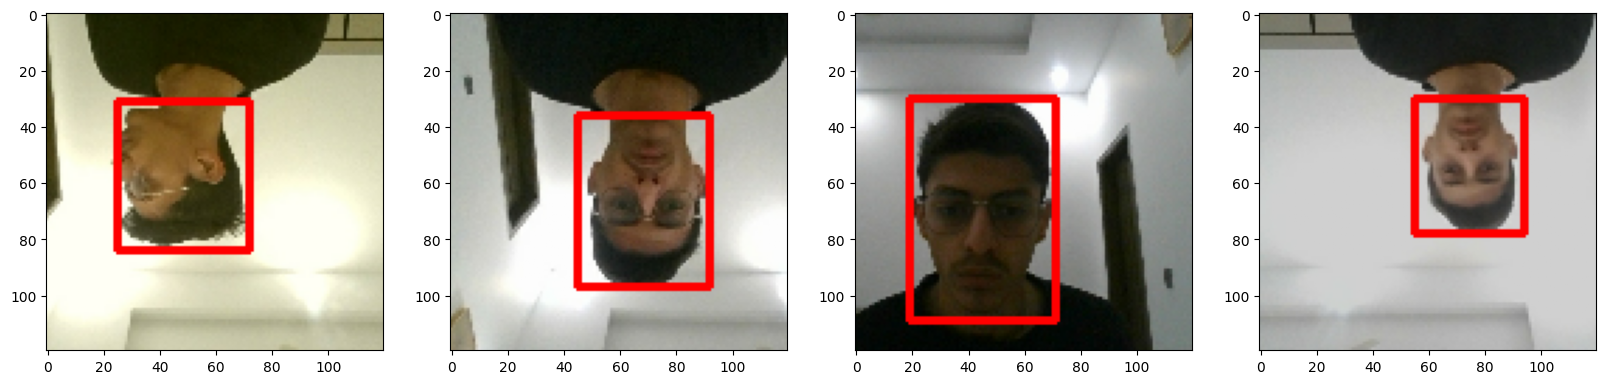

In [148]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_image = sample_image.copy()
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Building CNN Model Using VGG16

In [149]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.1 Importing Pre Trained Model

In [150]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 8.2 Connecting 2 Output Layers To VGG16

In [151]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    faceDetector = Model(inputs=input_layer, outputs=[class2, regress2])
    return faceDetector

In [152]:
facetracker = build_model()

# 9. Custom Loss And Optimizer

## 9.1 Batches Per Epoch

In [153]:
batches_per_epoch = len(train)

## 9.2 Learning Decay

In [ ]:
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
lr_decay

0.0007936507936507934

## 9.3 Optimizer

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## 9.4 Loss

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# 10. Training

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

In [ ]:
for images, labels in train.take(1):
    print("Fixed image batch shape:", images.shape)

Fixed image batch shape: (8, 8, 120, 120, 3)


In [ ]:
train.as_numpy_iterator().next()[0] = tf.reshape(train.as_numpy_iterator().next()[0], (8,120, 120, 3))

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 2764800 values, but the requested shape has 345600 [Op:Reshape]

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 120, 120, 3), found shape=(None, None, 120, 120, None)